In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from flax import jax_utils
import jax
import ml_collections

import numpy as np
import matplotlib.pyplot as plt

import input_pipeline

In [2]:
config = ml_collections.ConfigDict()

config.image_size = (512, 1024)
config.dataset = "cityscapes:1.*.*"
config.num_classes = 20
config.batch_size = 1
config.cache = False
config.half_precision = False

In [3]:
def prepare_tf_data(xs):
    """Convert a input batch from tf Tensors to numpy arrays."""
    local_device_count = jax.local_device_count()

    def _prepare(x):
        # Use _numpy() for zero-copy conversion between TF and NumPy.
        x = x._numpy()

        # reshape (host_batch_size, height, width, 3) to
        # (local_devices, device_batch_size, height, width, 3)
        return x.reshape((local_device_count, -1) + x.shape[1:])

    return jax.tree_map(_prepare, xs)

In [4]:
def create_input_iter(dataset_builder, batch_size, image_size, dtype, train, cache):
    ds = input_pipeline.create_split(
        dataset_builder,
        batch_size,
        image_size=image_size,
        dtype=dtype,
        train=train,
        cache=cache,
    )
    it = map(prepare_tf_data, ds)
    it = jax_utils.prefetch_to_device(it, 2)
    return it

In [5]:
def get_input_dtype(half_precision):
    platform = jax.local_devices()[0].platform
    if half_precision:
        if platform == "tpu":
            input_dtype = tf.bfloat16
        else:
            input_dtype = tf.float16
    else:
        input_dtype = tf.float32

    return input_dtype 

In [6]:
local_batch_size = config.batch_size // jax.process_count()
input_dtype = get_input_dtype(config.half_precision)

In [7]:
dataset_builder = tfds.builder(config.dataset)
dataset_builder.download_and_prepare()
train_iter = create_input_iter(
    dataset_builder,
    local_batch_size,
    config.image_size,
    input_dtype,
    train=True,
    cache=config.cache
    )
eval_iter = create_input_iter(
    dataset_builder,
    local_batch_size,
    config.image_size,
    input_dtype,
    train=False,
    cache=config.cache,
)

In [8]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        print(np.unique(display_list[i][0]))
        plt.imshow(tf.keras.utils.array_to_img(display_list[i][0]))
        plt.axis('off')
    plt.show()

[-1.4466542 -1.4447614 -1.4418995 ...  2.556999   2.565789   2.5739613]
[0 1]


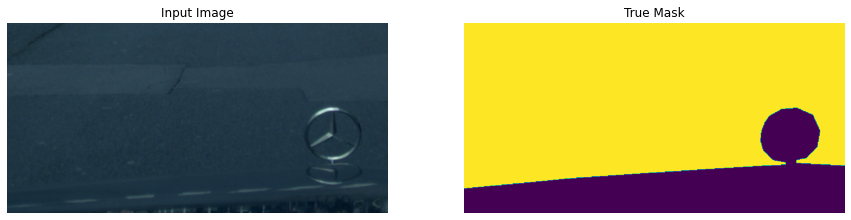

[-1.069816  -1.0624156 -1.0621802 ...  1.6121167  1.6179     1.61822  ]
[1 2]


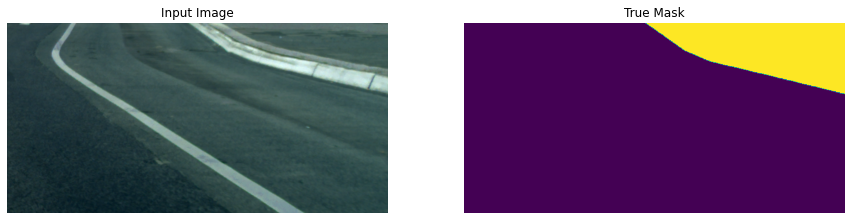

[-1.6198477 -1.6195318 -1.60258   ...  1.5900129  1.5935426  1.601527 ]
[ 0  1  2  4 12]


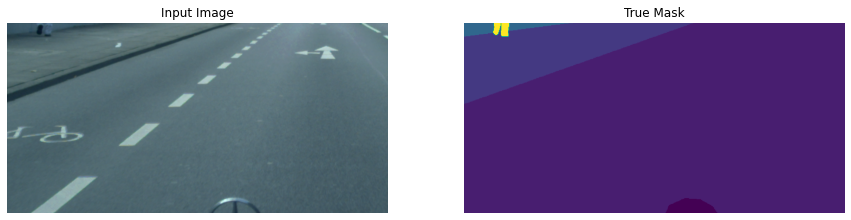

[-1.9177498 -1.8625576 -1.8610326 ...  1.391792   1.4040766  1.4058651]
[ 0  1  3  5  6  7  8  9 10 14]


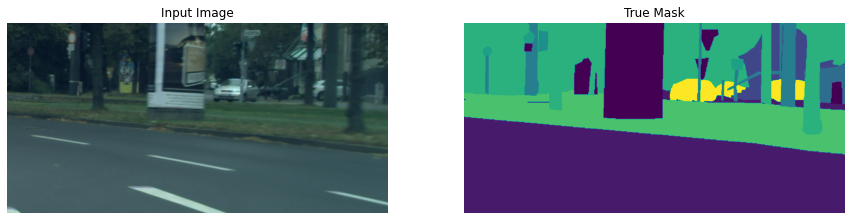

[-1.8433921 -1.8414743 -1.8346106 ...  1.2981987  1.3043356  1.3135109]
[1 2 3 9]


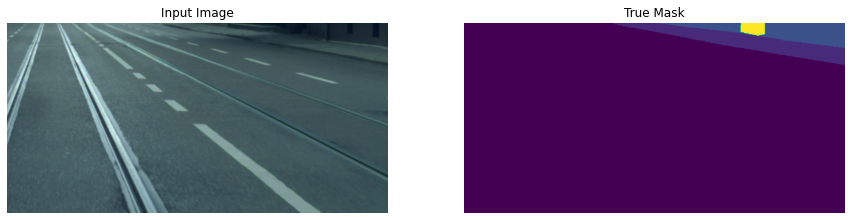

In [9]:
for _ in range(5):
    train_batch = next(train_iter)
    image = train_batch["image"]
    label = train_batch["label"]
    display([np.array(image[0]), np.array(label[0])])

[-1.9894683 -1.9766247 -1.9680624 ...  2.6312857  2.6356428  2.64     ]
[ 0  1  2  3  4  5  6  7  8  9 11 13 14 15 16 18 19]


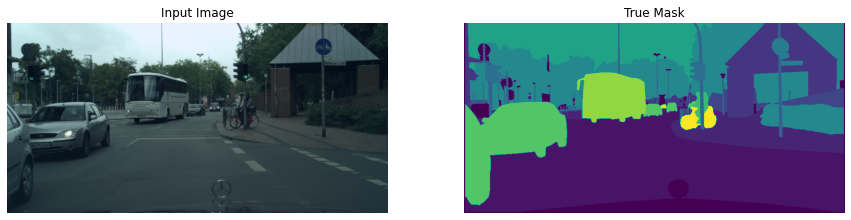

[-1.9338129 -1.9295317 -1.9252505 ...  2.6312857  2.6356428  2.64     ]
[ 0  1  2  3  4  6  7  8  9 11 12 13 14 19]


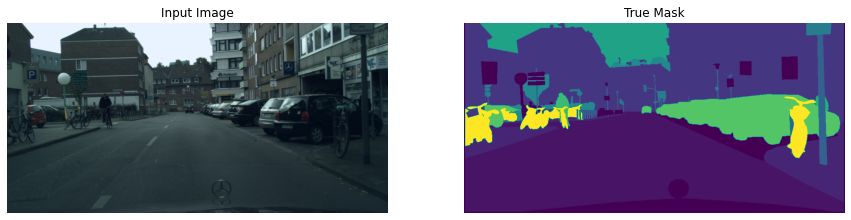

[-2.117904  -2.1136227 -2.1093416 ...  2.6312857  2.6356428  2.64     ]
[ 0  1  2  3  5  6  8  9 11 12 13 14 16 19]


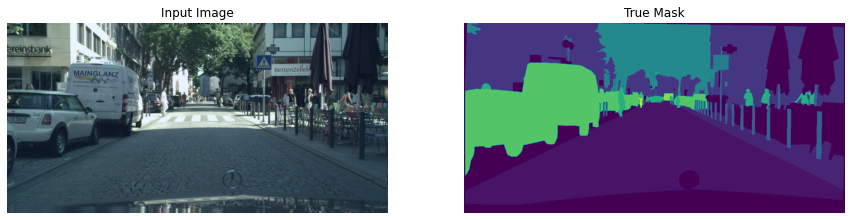

[-2.117904  -2.1136227 -2.1093416 ...  2.6312857  2.6356428  2.64     ]
[ 0  1  2  3  4  5  6  7  8  9 11 12 14 19]


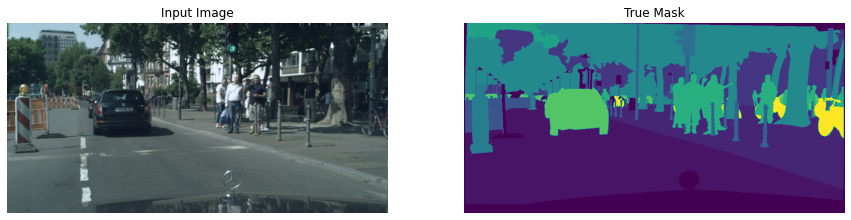

[-2.117904  -2.1136227 -2.1093416 ...  2.6312857  2.6356428  2.64     ]
[ 0  1  2  3  5  6  8  9 10 11 12 13 14 19]


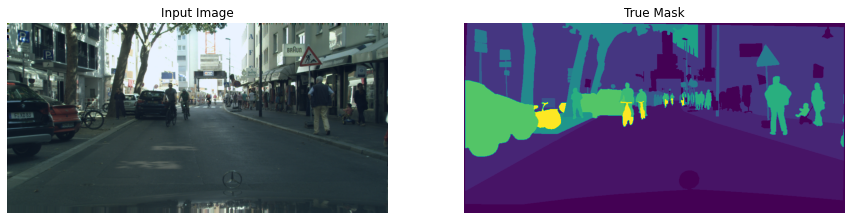

In [10]:
for _ in range(5):
    eval_batch = next(eval_iter)
    image = eval_batch["image"]
    label = eval_batch["label"]
    display([np.array(image[0]), np.array(label[0])])